## Two-dimensional advection equation

We want to solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} + v \frac{\partial \phi}{\partial y} = 0
\end{equation}

The independen variables (i.e, $x$, $y$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi(x,y,t)$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input.

In [1]:
# imports
import numpy as np 
import matplotlib.pyplot as plt 
import nangs
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__


Bad key "text.kerning_factor" on line 4 in
C:\Users\sensio\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


('0.1.1', '1.5.0')

In [2]:
from nangs import PDE

U, V = -0.5, 1

class Adv2d(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        grads = self.computeGrads(outputs, inputs)
        
        # compute loss
        dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        return {'pde': dpdt + U*dpdx + V*dpdy}
    
pde = Adv2d(inputs=('x', 'y', 't'), outputs='p')

In [3]:
# define the mesh

from nangs import Mesh

x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
t = np.linspace(0,1,20)

mesh = Mesh({'x': x, 'y': y, 't': t}, device=device)
pde.set_mesh(mesh)

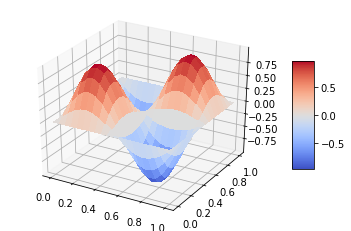

In [4]:
# initial condition (t = 0)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

t0 = np.array([0])
_x, _y = np.meshgrid(x, y)
p0 = np.sin(2*np.pi*_x)*np.sin(2*np.pi*_y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(_x, _y, p0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [5]:
from nangs import Dirichlet, Periodic

# initial condition
initial_condition = Dirichlet({'x': x, 'y': y, 't': t0}, {'p': p0.reshape(-1)}, device=device, name="initial")
pde.add_boco(initial_condition)

# periodic bocos
x1 = np.array([0.])
x2 = np.array([1.])
periodic1 = Periodic({'x': x1, 'y': y, 't': t}, {'x': x2, 'y': y, 't': t}, name="boco_x", device=device)
periodic2 = Periodic({'x': x, 'y': x1, 't': t}, {'x': x, 'y': x2, 't': t}, name="boco_y", device=device)
pde.add_boco(periodic1)
pde.add_boco(periodic2)

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.


In [6]:
from nangs import MLP

BATCH_SIZE = 256
LR = 1e-2
EPOCHS = 30
NUM_LAYERS = 3
NUM_HIDDEN = 128

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
hist = pde.solve(EPOCHS, BATCH_SIZE)

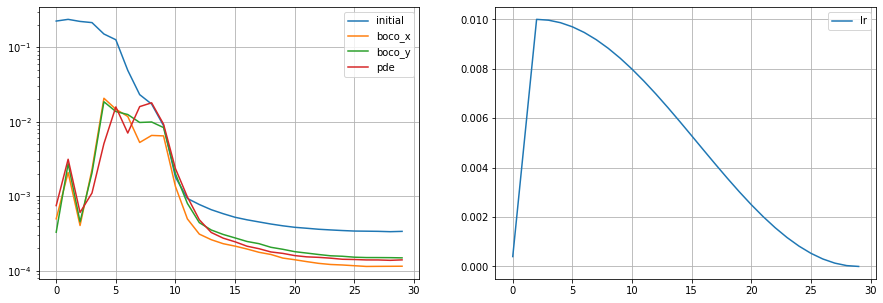

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
for name, vale in hist.items():
    if name is not 'lr':
        ax1.plot(hist[name], label=name)
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
ax2.plot(hist['lr'], label='lr')
ax2.grid(True)
ax2.legend()
plt.show()

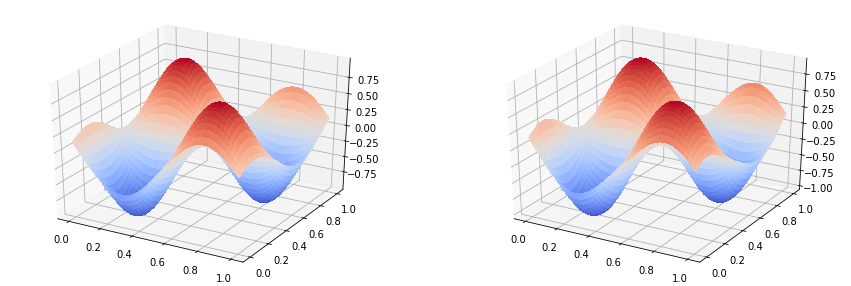

L2 error:  2.724122873137065


In [8]:
t = 0.912312
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

_x, _y = np.meshgrid(x, y)
p0 = np.sin(2*np.pi*(_x - U*t))*np.sin(2*np.pi*(_y - V*t))

eval_mesh = Mesh({'x': x, 'y': y, 't': t}, device=device)
p = pde.eval(eval_mesh)
p = p.cpu().numpy()

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot_surface(_x, _y, p0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.plot_surface(_x, _y, p.reshape((len(_y),len(_x))), cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()
print("L2 error: ", np.sqrt(sum((p0.ravel()-p.ravel())**2)))